In [1]:
import heeps

In [2]:
conf = dict(
    band = 'L',
    mode = 'RAVC',
    ravc_calc = False,
    dir_current = '$HOME/Desktop/heeps_analysis',
    dir_output = 'ravc_optim'
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf = heeps.pupil.pupil(savefits=True, verbose=True, **conf)

Update config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2568
   ravc_calc=False, ravc_t=0.7600, ravc_r=0.6200
   npupil=285, pscale=5.47 mas, lam=3.8112E-06 m
   ndet=365, hfov=1.0 arcsec (46.86 lam/D)

Load pupil from 'ELT_pupil_1385.fits'
   diam=36.91 m, resize to 285 pix, zero-pad to 1024 pix



In [8]:
rs = np.linspace(0.60, 0.64, 9) # centered on 0.64
ts = np.linspace(0.74, 0.78, 9) # centered on 0.76
rt = np.zeros((len(rs),len(ts)))
for i,r in enumerate(rs):
    for j,t in enumerate(ts):
        print(i,j)
        conf['ravc_r'] = r
        conf['ravc_t'] = t
        psf = heeps.wavefront.propagate_one(wf, tag='%s%s'%(i,j), onaxis=True, savefits=False, verbose=False, **conf)
        rt[i,j] = np.sum(psf)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8


([<matplotlib.axis.YTick at 0x7fbdfb061400>,
 <a list of 9 Text yticklabel objects>)

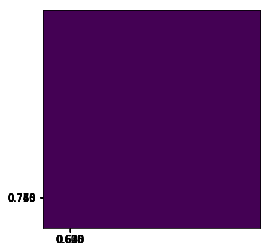

In [4]:
import matplotlib.pyplot as plt
plt.imshow(rt, origin='lower')
plt.xticks(rs)
plt.yticks(ts)

In [5]:
rt

array([[0.00129249, 0.00129249, 0.00129249, 0.00129249, 0.00129249,
        0.00129249, 0.00129249, 0.00129249, 0.00129249],
       [0.00129249, 0.00129249, 0.00129249, 0.00129249, 0.00129249,
        0.00129249, 0.00129249, 0.00129249, 0.00129249],
       [0.00129249, 0.00129249, 0.00129249, 0.00129249, 0.00129249,
        0.00129249, 0.00129249, 0.00129249, 0.00129249],
       [0.00129249, 0.00129249, 0.00129249, 0.00129249, 0.00129249,
        0.00129249, 0.00129249, 0.00129249, 0.00129249],
       [0.00129249, 0.00129249, 0.00129249, 0.00129249, 0.00129249,
        0.00129249, 0.00129249, 0.00129249, 0.00129249],
       [0.00129249, 0.00129249, 0.00129249, 0.00129249, 0.00129249,
        0.00129249, 0.00129249, 0.00129249, 0.00129249],
       [0.00129249, 0.00129249, 0.00129249, 0.00129249, 0.00129249,
        0.00129249, 0.00129249, 0.00129249, 0.00129249],
       [0.00129249, 0.00129249, 0.00129249, 0.00129249, 0.00129249,
        0.00129249, 0.00129249, 0.00129249, 0.00129249],
